In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

import pickle 
from pickle import dump
from pickle import load

#### Importing datframes with crime and green spaces

In [2]:
green_spaces = pd.read_excel('../Notebook/data_clean/green_spaces_summary.xlsx')
green_spaces.head()

,lor,subdistrict,area_objects,nb_objects,area_a,nb_a,area_f,nb_f,area_c,nb_c,area_p,nb_p,area_g,nb_g
0,11001,Tiergarten Süd,229.64,54,0.0,0,0.0,0,0.00,0,226.75,38,0.0,0
1,11002,Regierungsviertel,6.37,15,0.0,0,0.0,0,0.00,0,5.80,12,0.0,0
2,11003,Alexanderplatz,56.18,128,0.0,0,0.0,0,5.87,4,43.97,78,0.0,0
3,11004,Brunnenstraße Süd,26.79,26,0.0,0,0.0,0,12.64,3,10.33,9,0.0,0
4,12005,Moabit West,15.22,51,0.0,0,0.0,0,0.00,0,11.04,22,0.0,0


In [3]:
crime = pd.read_excel('../Notebook/data_clean/crime_2021_for_model.xlsx')
crime.head()

,lor,subdistrict,area,district,density,popul,crime_total,robbery,theft_bike,theft_other,bulglary,graffiti,drug_offences,hard_crime,other_crime
0,11001,Tiergarten Süd,517,Mitte,29.50,15249,25169,230,1541,8197,157,289,1312,2912,10532
1,11002,Regierungsviertel,270,Mitte,48.41,13071,45567,252,1882,13664,122,826,1316,4307,23196
2,11003,Alexanderplatz,623,Mitte,95.66,59594,26454,258,1248,9451,129,530,1438,3101,10298
3,11004,Brunnenstraße Süd,176,Mitte,179.07,31516,10788,133,1149,3544,102,324,400,1088,4049
4,12005,Moabit West,431,Mitte,105.97,45674,13207,105,849,3339,151,217,1141,1738,5666


#### Creating one dataframe for a model

In [4]:
green_spaces = green_spaces.drop(["lor", "subdistrict"], axis=1)

In [5]:
crime_gs = pd.concat([crime, green_spaces], axis=1)

In [6]:
crime_gs

,lor,subdistrict,area,district,density,popul,crime_total,robbery,theft_bike,theft_other,...,area_a,nb_a,area_f,nb_f,area_c,nb_c,area_p,nb_p,area_g,nb_g
0,11001,Tiergarten Süd,517,Mitte,29.50,15249,25169,230,1541,8197,...,0.00,0,0.00,0,0.00,0,226.75,38,0.00,0
1,11002,Regierungsviertel,270,Mitte,48.41,13071,45567,252,1882,13664,...,0.00,0,0.00,0,0.00,0,5.80,12,0.00,0
2,11003,Alexanderplatz,623,Mitte,95.66,59594,26454,258,1248,9451,...,0.00,0,0.00,0,5.87,4,43.97,78,0.00,0
3,11004,Brunnenstraße Süd,176,Mitte,179.07,31516,10788,133,1149,3544,...,0.00,0,0.00,0,12.64,3,10.33,9,0.00,0
4,12005,Moabit West,431,Mitte,105.97,45674,13207,105,849,3339,...,0.00,0,0.00,0,0.00,0,11.04,22,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,125008,West 3 - Borsigwalde/Freie Scholle,408,Reinickendorf,40.13,16372,6621,24,397,1936,...,21.05,6,8.10,1,16.55,4,6.75,15,21.05,6
139,125009,Nord 2 - Waidmannslust/Wittenau/Lübars,1180,Reinickendorf,27.19,32080,13223,84,346,3373,...,52.91,11,1.97,1,6.12,2,187.73,40,52.91,11
140,126010,Rollbergesiedlung,164,Reinickendorf,55.81,9153,9155,44,186,3868,...,13.48,4,0.00,0,0.00,0,7.60,4,13.48,4
141,126011,MV Nord,205,Reinickendorf,130.38,26728,7909,79,247,2604,...,6.78,2,0.00,0,0.00,0,3.41,5,6.78,2


#### Exporting concatinated file for analysis in QGIS and Tableau

In [7]:
crime_gs.to_excel('crime_vs_greensp.xlsx', index=False)

## Preparing data for clustering

In [8]:
# Checking for nulls
crime_gs.isna().sum().sum()

0

#### Features for clustering:
- all without: lor, subdistrict, district

In [9]:
crime_gs.columns

Index(['lor', 'subdistrict', 'area', 'district', 'density', 'popul',
       'crime_total', 'robbery', 'theft_bike', 'theft_other', 'bulglary',
       'graffiti', 'drug_offences', 'hard_crime', 'other_crime',
       'area_objects', 'nb_objects', 'area_a', 'nb_a', 'area_f', 'nb_f',
       'area_c', 'nb_c', 'area_p', 'nb_p', 'area_g', 'nb_g'],
      dtype='object')

In [10]:
X = crime_gs.drop(["lor", "subdistrict", "district"], axis=1)
X  # data for clustering

,area,density,popul,crime_total,robbery,theft_bike,theft_other,bulglary,graffiti,drug_offences,...,area_a,nb_a,area_f,nb_f,area_c,nb_c,area_p,nb_p,area_g,nb_g
0,517,29.50,15249,25169,230,1541,8197,157,289,1312,...,0.00,0,0.00,0,0.00,0,226.75,38,0.00,0
1,270,48.41,13071,45567,252,1882,13664,122,826,1316,...,0.00,0,0.00,0,0.00,0,5.80,12,0.00,0
2,623,95.66,59594,26454,258,1248,9451,129,530,1438,...,0.00,0,0.00,0,5.87,4,43.97,78,0.00,0
3,176,179.07,31516,10788,133,1149,3544,102,324,400,...,0.00,0,0.00,0,12.64,3,10.33,9,0.00,0
4,431,105.97,45674,13207,105,849,3339,151,217,1141,...,0.00,0,0.00,0,0.00,0,11.04,22,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,408,40.13,16372,6621,24,397,1936,128,43,147,...,21.05,6,8.10,1,16.55,4,6.75,15,21.05,6
139,1180,27.19,32080,13223,84,346,3373,209,249,315,...,52.91,11,1.97,1,6.12,2,187.73,40,52.91,11
140,164,55.81,9153,9155,44,186,3868,109,33,98,...,13.48,4,0.00,0,0.00,0,7.60,4,13.48,4
141,205,130.38,26728,7909,79,247,2604,49,34,168,...,6.78,2,0.00,0,0.00,0,3.41,5,6.78,2


#### Checking for multicolinearity

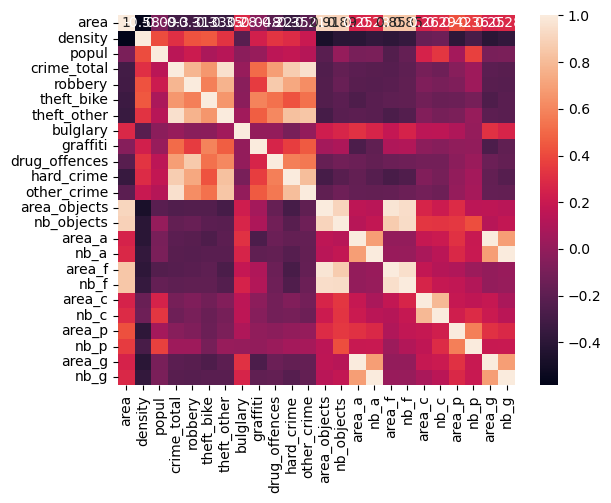

In [11]:
# Correlation matric and Heatmap
correlations_matrix = X.corr() # Creating correlation matrix for all x-values 
sns.heatmap(correlations_matrix, annot=True) # Creating a heatmap from that
plt.show()

- I am deciding not to drop any features, as they are all important to create a clustering. 

### Scaling

In [12]:
scaler = MinMaxScaler().fit(X) 

In [13]:
X_scal = scaler.transform(X)

In [14]:
pd.DataFrame(X_scal,columns=X.columns).head()

,area,density,popul,crime_total,robbery,theft_bike,theft_other,bulglary,graffiti,drug_offences,...,area_a,nb_a,area_f,nb_f,area_c,nb_c,area_p,nb_p,area_g,nb_g
0,0.104572,0.084794,0.182239,0.520521,0.373377,0.623564,0.578456,0.354430,0.272201,0.216980,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.836188,0.480519,0.0,0.0
1,0.046659,0.144513,0.146100,1.000000,0.409091,0.768609,1.000000,0.265823,0.790541,0.217656,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.018793,0.142857,0.0,0.0
2,0.129426,0.293731,0.918048,0.550726,0.418831,0.498937,0.675148,0.283544,0.504826,0.238289,...,0.0,0.0,0.0,0.0,0.078834,0.444444,0.160001,1.000000,0.0,0.0
3,0.024619,0.557145,0.452155,0.182478,0.215909,0.456827,0.219678,0.215190,0.305985,0.062743,...,0.0,0.0,0.0,0.0,0.169756,0.333333,0.035552,0.103896,0.0,0.0
4,0.084408,0.326291,0.687076,0.239340,0.170455,0.329222,0.203871,0.339241,0.202703,0.188060,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038178,0.272727,0.0,0.0


### Chosing k

In [15]:
kmeans = KMeans(n_clusters=5, random_state=1234)
kmeans.fit(X_scal)

C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=1234)

C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

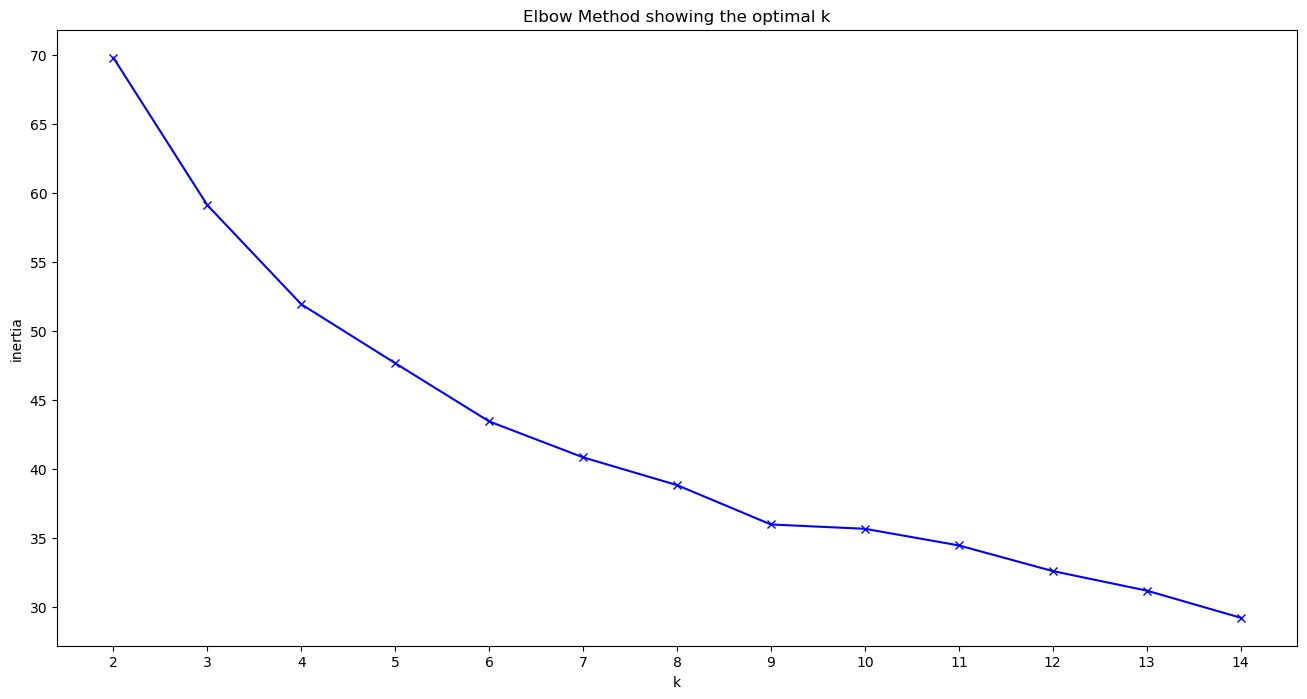

In [16]:
K = range(2, 15)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scal)
    inertia.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_

Text(0.5, 1.0, 'Silhouette score showing the optimal k')

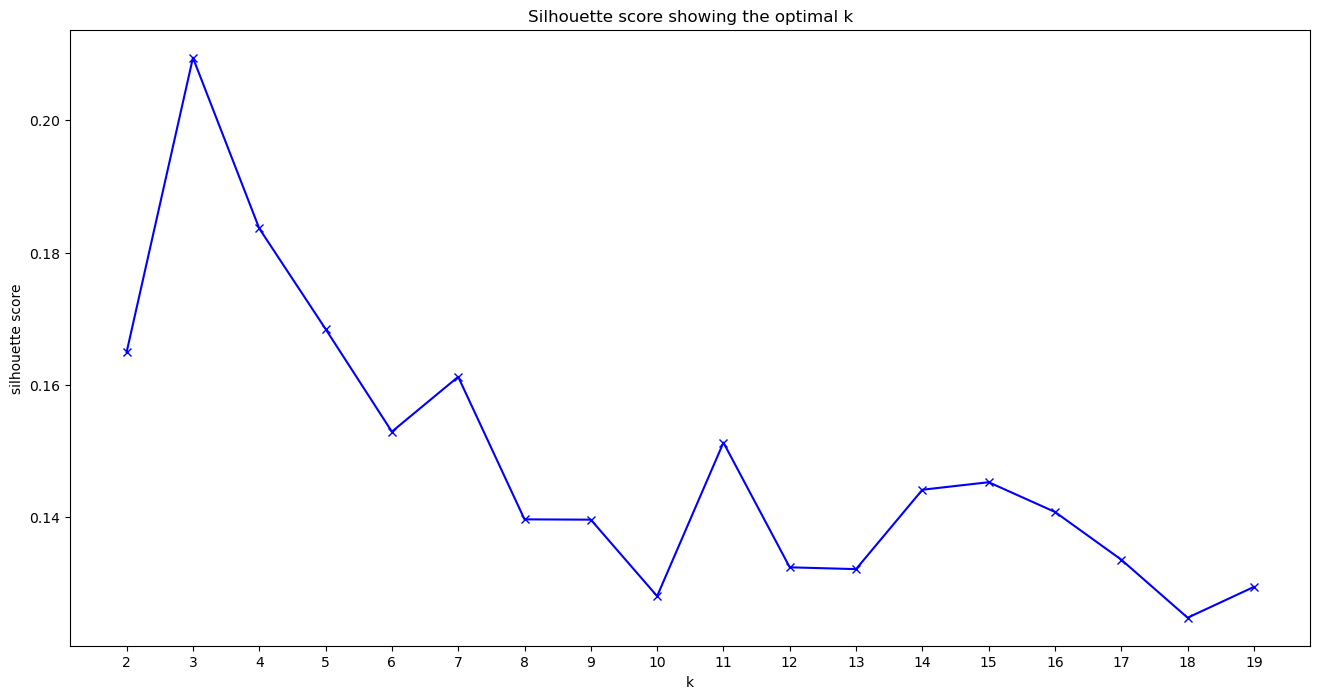

In [17]:
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scal)
    silhouette.append(silhouette_score(X_scal, kmeans.predict(X_scal)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette score showing the optimal k')

#### Conclusions:

- The plot with ellbow score is not very clear, where the ellbow is. There could be a few points, e.g. 6 or 7, 9. 
- Silhouette score has few high points: 3, 7, 11.
- Considering the task I have (creating clusters for subdistricts) it would not be good to take too little clusters into consideration, as well as not too many (because then clustering doesnt make sense). 
- This is why I would decide to take into consideration the k=7.

### Clustering subdistricts

In [18]:
kmeans = KMeans(n_clusters=7, random_state=1234) 
kmeans.fit(X_scal)

C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\e\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=7, random_state=1234)

In [19]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_scal)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    20
1    27
2    10
3     7
4    30
5    46
6     3
Name: count, dtype: int64

### Creating an output dataframe

In [20]:
col = ["cluster"]
df = pd.DataFrame(clusters, columns=col)
df   # dataframe with the feature "cluster"

,cluster
0,2
1,2
2,2
3,4
4,4
...,...
138,1
139,0
140,5
141,5


In [21]:
df_final = pd.concat([crime_gs, df], axis=1)

In [22]:
df_final

,lor,subdistrict,area,district,density,popul,crime_total,robbery,theft_bike,theft_other,...,nb_a,area_f,nb_f,area_c,nb_c,area_p,nb_p,area_g,nb_g,cluster
0,11001,Tiergarten Süd,517,Mitte,29.50,15249,25169,230,1541,8197,...,0,0.00,0,0.00,0,226.75,38,0.00,0,2
1,11002,Regierungsviertel,270,Mitte,48.41,13071,45567,252,1882,13664,...,0,0.00,0,0.00,0,5.80,12,0.00,0,2
2,11003,Alexanderplatz,623,Mitte,95.66,59594,26454,258,1248,9451,...,0,0.00,0,5.87,4,43.97,78,0.00,0,2
3,11004,Brunnenstraße Süd,176,Mitte,179.07,31516,10788,133,1149,3544,...,0,0.00,0,12.64,3,10.33,9,0.00,0,4
4,12005,Moabit West,431,Mitte,105.97,45674,13207,105,849,3339,...,0,0.00,0,0.00,0,11.04,22,0.00,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,125008,West 3 - Borsigwalde/Freie Scholle,408,Reinickendorf,40.13,16372,6621,24,397,1936,...,6,8.10,1,16.55,4,6.75,15,21.05,6,1
139,125009,Nord 2 - Waidmannslust/Wittenau/Lübars,1180,Reinickendorf,27.19,32080,13223,84,346,3373,...,11,1.97,1,6.12,2,187.73,40,52.91,11,0
140,126010,Rollbergesiedlung,164,Reinickendorf,55.81,9153,9155,44,186,3868,...,4,0.00,0,0.00,0,7.60,4,13.48,4,5
141,126011,MV Nord,205,Reinickendorf,130.38,26728,7909,79,247,2604,...,2,0.00,0,0.00,0,3.41,5,6.78,2,5


#### Export df_final

In [23]:
df_final.to_excel('clusters_subdistricts.xlsx', index=False)

In [24]:
df_final.to_csv('clusters_subdistricts.csv', index=False)